# Random forest pipeline
The jupyter notebook for good permeaters prediction using random forest model  
Including hyper-parameter tuning, leave-one-out cross validation, and feature importance extraction  

Auther: Yue (Shawn) Shen  
Date: Jun 08, 2021  

In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read raw data
df = pd.read_csv('dataset.csv')

if df.isnull().values.any():
    print ('missing values!')
else:
    print('pass')

df.head()

pass


,MolID,target_permeator,BalabanJ,BertzCT,Chi0,Chi1,Chi0n,Chi1n,Chi2n,Chi3n,...,PMI3,RadiusOfGyration,SpherocityIndex,avg_asphericity,avg_acylindricity,avg_kappa2,avg_rg,avg_largest_principal_rg,avg_middle_principal_rg,avg_smallest_principal_rg
0,1500272,0,1.429,1053.463,24.526,17.092,21.986,13.271,10.508,8.949,...,8960.40,4.71,0.26,0.377154,0.212826,0.287922,0.526401,0.505270,0.457168,0.299362
1,1501007,0,1.868,592.306,16.113,10.436,12.477,7.260,5.618,3.565,...,5322.33,4.43,0.13,0.310194,0.123611,0.349557,0.411174,0.391925,0.369452,0.216417
2,1501150,1,2.143,675.300,17.035,10.863,13.464,7.701,5.718,4.335,...,4454.32,3.82,0.13,0.307322,0.156884,0.302154,0.421545,0.403439,0.370261,0.235260
3,1503100,1,1.453,912.788,20.096,13.507,16.903,9.734,7.208,5.436,...,6975.32,4.50,0.21,0.402013,0.129149,0.435131,0.498724,0.478465,0.459285,0.236546
4,1503243,0,1.847,673.567,17.527,11.469,13.852,8.151,6.130,4.164,...,6455.60,4.67,0.11,0.365638,0.124397,0.441792,0.454138,0.437384,0.416621,0.212002


## 1. Hyper-parameter tuning

In [7]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score,roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, ParameterGrid, cross_val_predict

RF_param_grid = {"n_estimators" : [100, 200, 400, 800],
                 "min_samples_leaf" : [1,2],
                 "max_features" : [None,'sqrt','log2']}

def grid_search_loocv(X, y, estimator, sampler, param_grid):
    # search for best hyper-parameter in leave-one-out style
    from operator import itemgetter
    cv = LeaveOneOut()
    param_combinations = ParameterGrid(param_grid)
    result_list = []
    Y_pred = np.array([])
    metric_cols=['F1','precision','recall','accuracy', 'AUROC','confusion_matrix', 'hyper-parameter combination']
    print("---all combinations with score metrics---")
    print('|'.join(metric_cols)) # title row
    
    for param in param_combinations:
        model = Pipeline([('over-sampling', sampler), ('clf', estimator.set_params(**param))])
        pred_probs = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict_proba')
        Y_pred = pred_probs.argmax(axis=1)

        # claculate metrics
        f1 = round(f1_score(y,Y_pred),3)
        prec = round(precision_score(y,Y_pred),3)
        recall = round(recall_score(y,Y_pred),3)
        acc = round(accuracy_score(y,Y_pred),3)
        AUC = round(roc_auc_score(y, pred_probs[:,1]),3)
        conf = confusion_matrix(y,Y_pred).tolist()

        print((f1, prec, recall, acc, AUC, conf, param))
        result_list.append((f1, prec, recall, acc, AUC, conf, param))

    top_param = max(result_list,key=itemgetter(3)) # rank by accuracy
    print("---------------------")
    print(f"tuned parameteres:{top_param}\n") # best parameters combination
    
    return top_param[-1]

In [3]:
Ycolumn = 'target_permeator'

descriptors = ['PMI1','avg_smallest_principal_rg','NumHDonors','TPSA','avg_kappa2','avg_rg','Kappa3','NumRotatableBonds','HallKierAlpha','FpDensityMorgan2','NumHAcceptors','NumHeteroatoms','LabuteASA','NumAromaticCarbocycles','NumAromaticRings','NPR2','EState_VSA2','MaxAbsEStateIndex','NumAliphaticHeterocycles','FractionCSP3','NumAliphaticCarbocycles','MinAbsEStateIndex','MinPartialCharge','NumAromaticHeterocycles','NPR1','MaxAbsPartialCharge','MinEStateIndex','avg_acylindricity','MinAbsPartialCharge','MolLogP'] # Features after clustering

# specify X and Y
Y = df.iloc[:, 1]
X_raw = df.iloc[:, 2:]

if Y.isnull().values.any():
    print("Warning: NaN found")

# standardize X to have mean and std 0 and 1
X = StandardScaler().fit_transform(X_raw[descriptors])
Y = Y.to_numpy()

# count positive and negative samples to show skewness
# print(f"#positive/negative: {sum(Y)}/{len(Y)-sum(Y)}")

RF = RandomForestClassifier(random_state=0)
sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=9, random_state=22), k_neighbors=2, cluster_balance_threshold=0.2, n_jobs=-1, random_state=22)

top_param = grid_search_loocv(X, Y, RF, sampler, RF_param_grid)

#positive/negative: 20/63
---all combinations with score metrics---
F1|precision|recall|accuracy|AUROC|confusion_matrix|hyper-parameter combination
(0.486, 0.529, 0.45, 0.771, 0.632, [[55, 8], [11, 9]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100})
(0.444, 0.5, 0.4, 0.759, 0.629, [[55, 8], [12, 8]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200})
(0.444, 0.5, 0.4, 0.759, 0.639, [[55, 8], [12, 8]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400})
(0.444, 0.5, 0.4, 0.759, 0.644, [[55, 8], [12, 8]], {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 800})
(0.514, 0.6, 0.45, 0.795, 0.656, [[57, 6], [11, 9]], {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100})
(0.5, 0.562, 0.45, 0.783, 0.656, [[56, 7], [11, 9]], {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 200})
(0.5, 0.562, 0.45, 0.783, 0.648, [[56, 7], [11, 9]], {'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 400})
(0.485

## 2. Leave-one-out cross validation with tunned hyper-parameter set

---leave one out validation with best parameter set---
      F1  precision  recall  accuracy  AUROC    confusion_matrix
0  0.514        0.6    0.45     0.795  0.656  [[57, 6], [11, 9]]


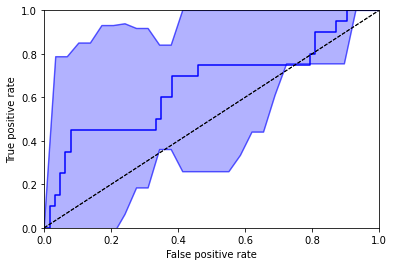

In [9]:
def loocv(X, Y, hyperparam):
    cv = LeaveOneOut()
    print("---leave one out validation with best parameter set---")
    RF = RandomForestClassifier(random_state=0)
    sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=9, random_state=22), k_neighbors=2, cluster_balance_threshold=0.2, n_jobs=-1, random_state=22)
    final_model = Pipeline([('over-sampling', sampler), ('clf', RF.set_params(**top_param))])
    pred_probs = cross_val_predict(final_model, X, Y, cv=cv, n_jobs=-1, method='predict_proba')
    Y_pred = pred_probs.argmax(axis=1)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(Y,pred_probs[:,1])
    plt.plot(fpr, tpr, color='b')
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')

    # scoring metrics
    f1 = round(f1_score(Y,Y_pred),3)
    prec = round(precision_score(Y,Y_pred),3)
    recall = round(recall_score(Y,Y_pred),3)
    acc = round(accuracy_score(Y,Y_pred),3)
    AUC = round(roc_auc_score(Y, pred_probs[:,1]),3)
    conM = confusion_matrix(Y,Y_pred).tolist()
    metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))

    # confidence interval bands with 5-fold cross validation
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    tprs = []
    fprs = []
    for train_index, val_index in cv.split(X, Y):

        X_train, X_val, Y_train, Y_val = X[train_index], X[val_index], Y[train_index], Y[val_index]

        pred_probs = final_model.fit(X_train, Y_train).predict_proba(X_val)
        Y_pred = pred_probs.argmax(axis=1) # get predicted value from probability of two classes

        fpr, tpr, _ = roc_curve(Y_val,pred_probs[:,1])
        tprs.append(tpr)
        fprs.append(fpr)

    # calculate mean and std from cross validation
    fpr_mean    = np.linspace(0, 1, 30)
    interp_tprs = []
    for i in range(5):
        fp = fprs[i]
        tp = tprs[i]
        interp_tpr = np.interp(fpr_mean, fp, tp)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    tpr_mean = np.mean(interp_tprs, axis=0)
    tpr_mean[-1] = 1.0
    tpr_std = 1.96*np.std(interp_tprs, axis=0) # 1.96 stands for 95% CI
    tpr_upper = np.clip(tpr_mean+tpr_std, 0, 1)
    tpr_lower = tpr_mean-tpr_std

    plt.plot(fpr_mean, tpr_upper, color='b', alpha=0.5)
    plt.plot(fpr_mean, tpr_lower, color='b', alpha=0.5)
    plt.fill_between(fpr_mean, tpr_upper, tpr_lower, color='b', alpha=0.3)
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.show()

    return

loocv(X, Y, top_param)

## 3. Feature importance

In [16]:
def get_importance(X, Y, clf, hyperparam, descriptors):
    model = clf.set_params(**top_param)
    model.fit(X,Y)
    feature_importance = model.feature_importances_
    # print(descriptors)
    importance_df = pd.DataFrame({'descriptor':descriptors, 'importance':feature_importance})
    importance_df.sort_values(by=['importance'], ascending=False, inplace=True)
    return importance_df

print(get_importance(X, Y, RF, top_param, descriptors))

                   descriptor  importance
28        MinAbsPartialCharge    0.187798
4                  avg_kappa2    0.125205
27          avg_acylindricity    0.115232
26             MinEStateIndex    0.094314
12                  LabuteASA    0.050541
1   avg_smallest_principal_rg    0.046913
14           NumAromaticRings    0.042237
19               FractionCSP3    0.029633
25        MaxAbsPartialCharge    0.026964
17          MaxAbsEStateIndex    0.026801
21          MinAbsEStateIndex    0.026562
29                    MolLogP    0.025476
5                      avg_rg    0.025367
8               HallKierAlpha    0.023939
6                      Kappa3    0.019097
16                EState_VSA2    0.017849
9            FpDensityMorgan2    0.016439
3                        TPSA    0.016176
22           MinPartialCharge    0.016039
24                       NPR1    0.015461
10              NumHAcceptors    0.010939
7           NumRotatableBonds    0.010495
15                       NPR2    0